In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import models
import numpy as np

import random
import os
import time

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

from imagenet.imagenet_labels import imagenet_labels_dict
from shearletx import ShearletX
from waveletx import WaveletX
from cartoonx import CartoonX
from smoothmask import SmoothMask

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

plt.rcParams["font.family"] = "Times New Roman"

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

/home/groups/ai/kolek/miniconda3/envs/scat/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Model 
We first compute explanation masks for the [VGG19](https://arxiv.org/pdf/1409.1556v6.pdf) model on for an image of a frog for <u>ShearletX</u> (ours), <u>WaveletX</u> (ours), [CartoonX](https://www.ecva.net/papers/eccv_2022/papers_ECCV/papers/136720439.pdf), [Smoothmask](https://www.robots.ox.ac.uk/~vedaldi/assets/pubs/fong19understanding.pdf), and [GradCAM](https://arxiv.org/pdf/1610.02391.pdf).

In [2]:
# Get device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Define input normalization layer for imagenet images
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean, device=device, requires_grad=False)
        self.std = torch.tensor(std, device=device, requires_grad=False)

    def forward(self, x):
        x = x - self.mean.reshape(self.mean.size(0),1,1)
        x = x / self.std.reshape(self.std.size(0),1,1)
        return x

# Get model
network = models.vgg19(pretrained=True).eval().to(device)
# Add input normalization layer
model = nn.Sequential(Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), network)

### Load Image
We will start explaining the classification decision of a [Tree Frog](https://en.wikipedia.org/wiki/Tree_frog) for the image below.

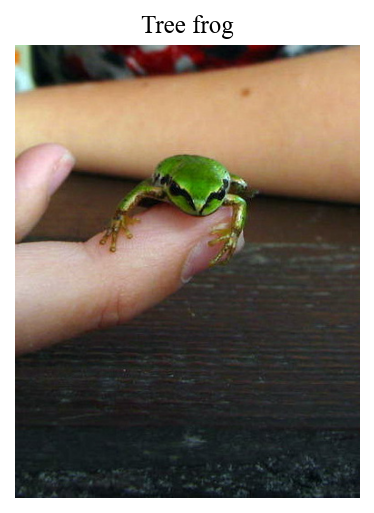

In [3]:
convert_to_tensor = transforms.Compose(
    [transforms.ToTensor(), transforms.Resize(size=(256,256))]
)
    

img = Image.open(os.path.join('imgs', 'ILSVRC2012_val_00041279.JPEG')).convert('RGB')
# Convert image to tensor
x = convert_to_tensor(img).unsqueeze(0).to(device)
# Get prediction for x
preds = nn.Softmax(dim=-1)(model(x)).max(1)[1].detach()

# Plot the image
plt.subplots(dpi=150)
plt.imshow(img)
plt.axis('off')
plt.title(imagenet_labels_dict[preds[0].item()].split(',')[0].capitalize())


# Show the plot
plt.show()


### Mask Explanations
A mask explanation optimizes an explanation mask tensor with values between zero and one on an input representation. The objective is to delete as much as possible while retaining the model output. To quantify the performance of a mask, we compute the <u>retained probability</u> and <u>retained information<\u> in the masked image. These metrics are computed as:
    
- retained probability = (Class Probability Masked Image) / (Class Probability Image)
- retained information = (Information Masked Image) / (Information Image)

One can compute the information of the image in various ways. For simplicity, in this notebook we compute the information of the image as the l1 norm of the image although, as we argue in our paper, the entropy in the image representation may be more appropriate.
    

### ShearletX
<u>Hyperparameters:</u> 
- `l1lambda` = multiplier for l1 norm of shearlet mask
- `lr` = learning rate for optimization of shearlet mask
- `obfuscation` = noise perturbation distribution for mask ['uniform', 'gaussian']
- `optim_steps` = number of steps that optimize the mask
- `noise_bs` = batch size for noise perturbations
- `l1_reg` = multiplier for l1 spatial (pixelspace) regularization
- `mask_init` = initial mask (works best with all ones as initial mask)

Iter 149/150
Time: 48.09


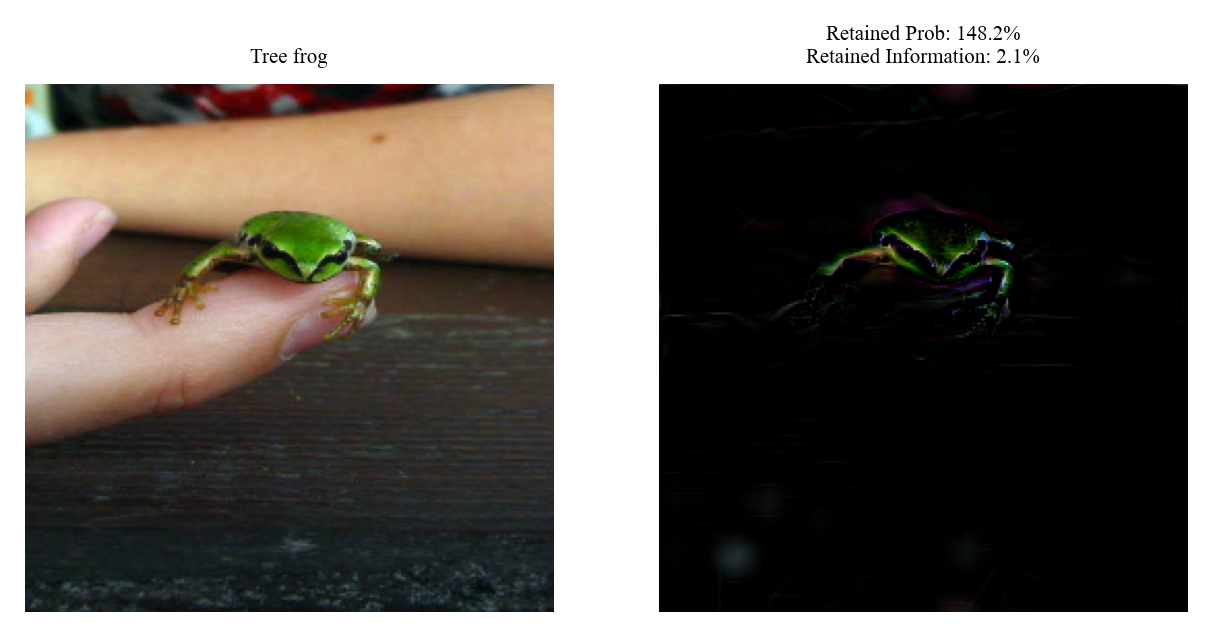

In [4]:
# Hparams ShearletX with spatial reg
SHEARLETX_HPARAMS = {
    "l1lambda": 1., "lr": 1e-1, 'obfuscation': 'uniform',
    "maximize_label": True, "optim_steps": 150,  
    "noise_bs": 16, 'l1_reg': 3.5, 'mask_init': 'ones'
} 

# ============================== Compute ShearletX ===============================
t = time.time()
shearletx_method = ShearletX(model=model, device=device, **SHEARLETX_HPARAMS)
shearletx, history_shearletx = shearletx_method(x, preds)
shearletx = shearletx/shearletx.max()
print(f'\nTime: {time.time()-t:.2f}')

# ============================== Plot Explanation ==============================
fig, axs = plt.subplots(1,2, dpi=250)
s = 6 # fontsize
# Input Image
axs[0].imshow(x.squeeze(0).permute(1,2,0).cpu())
axs[0].set_title(imagenet_labels_dict[preds[0].item()].split(',')[0].capitalize(), fontsize=s)
axs[0].axis('off')

# ShearletX Visualization
axs[1].imshow(shearletx.squeeze(0).permute(1,2,0).cpu())
axs[1].axis('off')
fidelity = nn.Softmax(dim=-1)(model(shearletx)).max(1)[0].item()
acc = nn.Softmax(dim=-1)(model(x)).max(1)[0].item()
retained_prob_shearletx = fidelity / acc
retained_information_shearletx = shearletx.abs().sum() / x.abs().sum()
axs[1].set_title(f'Retained Prob: {(100*retained_prob_shearletx):.1f}%\nRetained Information: {(100*retained_information_shearletx):.1f}%', fontsize=s)
plt.show()

### WaveletX
<u>Hyperparameters:</u> 
- `l1lambda` = multiplier for l1 norm of wavelet mask
- `lr` = learning rate for optimization of wavelet mask
- `obfuscation` = noise perturbation distribution for mask ['uniform', 'gaussian']
- `optim_steps` = number of steps that optimize the mask
- `noise_bs` = batch size for noise perturbations
- `l1_reg` = multiplier for l1 spatial (pixelspace) regularization
- `mask_init` = initial mask (works best with all ones as initial mask)

Iter 149/150
Time: 18.82


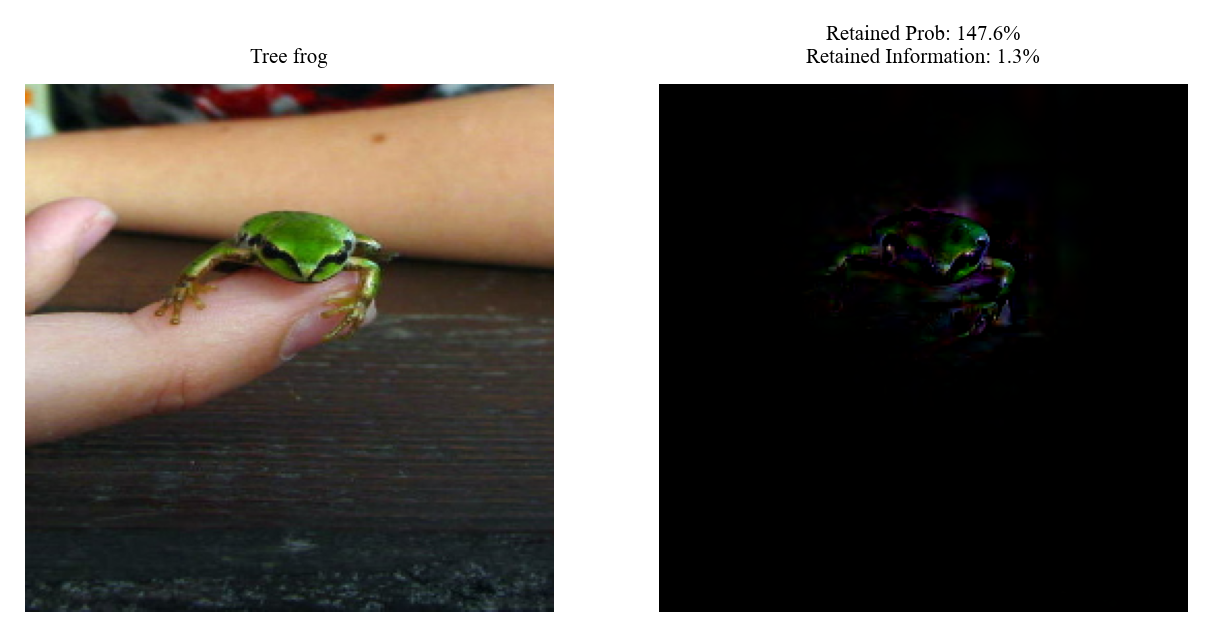

In [5]:
# Hparams WaveletX with spatial reg
WAVELETX_HPARAMS = {
    "l1lambda": 1., "lr": 1e-1, 'obfuscation': 'uniform',
    "maximize_label": True, "optim_steps": 150,  
    "noise_bs": 16, 'l1_reg': 35., 'mask_init': 'ones'
} 

# ============================== Compute WaveletX ===============================
t = time.time()
waveletx_method = WaveletX(model=model, device=device, **WAVELETX_HPARAMS)
waveletx, history_waveletx = waveletx_method(x, preds)
waveletx = waveletx/waveletx.max()
print(f'\nTime: {time.time()-t:.2f}')

# ============================== Plot Explanation ==============================
fig, axs = plt.subplots(1,2, dpi=250)
s = 6 # fontsize
# Input Image
axs[0].imshow(x.squeeze(0).permute(1,2,0).cpu())
axs[0].set_title(imagenet_labels_dict[preds[0].item()].split(',')[0].capitalize(), fontsize=s)
axs[0].axis('off')

# WaveletX Visualization
axs[1].imshow(waveletx.squeeze(0).permute(1,2,0).cpu())
axs[1].axis('off')
fidelity = nn.Softmax(dim=-1)(model(waveletx)).max(1)[0].item()
acc = nn.Softmax(dim=-1)(model(x)).max(1)[0].item()
retained_prob_waveletx = fidelity / acc
retained_information_waveletx = waveletx.abs().sum() / x.abs().sum()
axs[1].set_title(f'Retained Prob: {(100*retained_prob_waveletx):.1f}%\nRetained Information: {(100*retained_information_waveletx):.1f}%', fontsize=s)
plt.show()

### CartoonX
*Note that [CartoonX](https://www.ecva.net/papers/eccv_2022/papers_ECCV/papers/136720439.pdf) is WaveletX with zero spatial regularization.*

<u>Hyperparameters:</u> 
- `l1lambda` = multiplier for l1 norm of wavelet mask
- `lr` = learning rate for optimization of wavelet mask
- `obfuscation` = noise perturbation distribution for mask ['uniform', 'gaussian']
- `optim_steps` = number of steps that optimize the mask
- `noise_bs` = batch size for noise perturbations
- `mask_init` = initial mask (works best with all ones as initial mask)

Iter 149/150
Time: 18.63


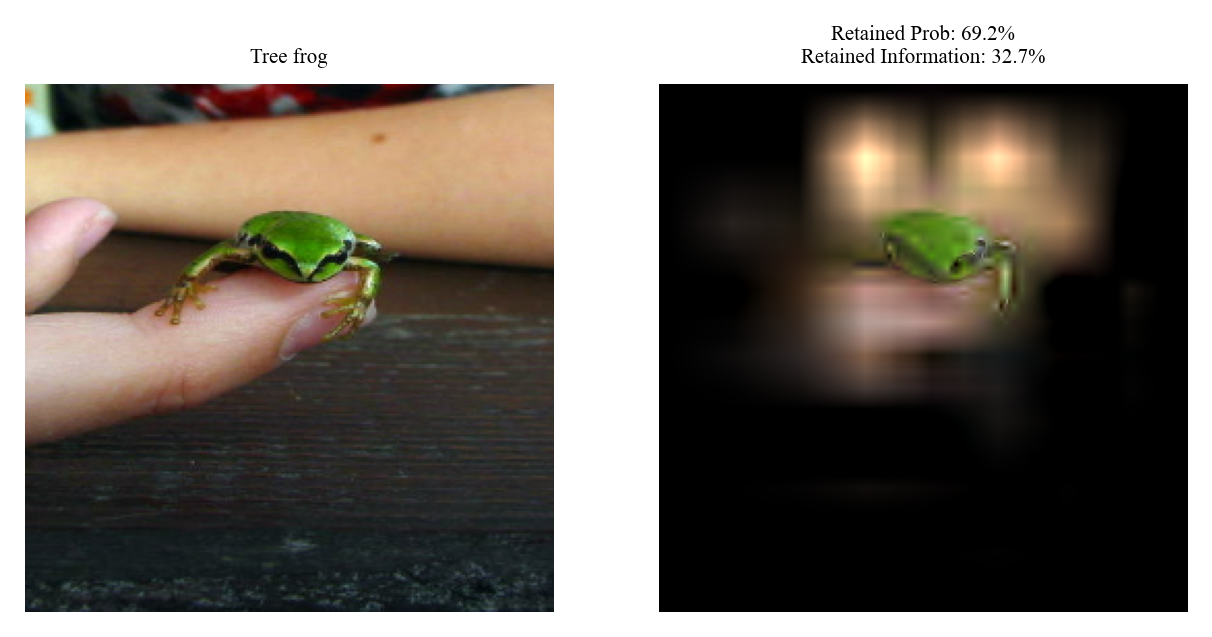

In [6]:
# Hparams WaveletX with spatial reg
CARTOONX_HPARAMS = {
    "l1lambda": 155., "lr": 1e-1, 'obfuscation': 'uniform',
    "maximize_label": True, "optim_steps": 150,  
    "noise_bs": 16, 'mask_init': 'ones'
} 

# ============================== Compute CartoonX ===============================
t = time.time()
cartoonx_method = CartoonX(model=model, device=device, **CARTOONX_HPARAMS)
cartoonx, history_cartoonx = cartoonx_method(x, preds)
cartoonx = cartoonx/cartoonx.max()
print(f'\nTime: {time.time()-t:.2f}')

# ============================== Plot Explanation ==============================
fig, axs = plt.subplots(1,2, dpi=250)
s = 6 # fontsize
# Input Image
axs[0].imshow(x.squeeze(0).permute(1,2,0).cpu())
axs[0].set_title(imagenet_labels_dict[preds[0].item()].split(',')[0].capitalize(), fontsize=s)
axs[0].axis('off')

# CartoonX Visualization
axs[1].imshow(cartoonx.squeeze(0).permute(1,2,0).cpu())
axs[1].axis('off')
fidelity = nn.Softmax(dim=-1)(model(cartoonx)).max(1)[0].item()
acc = nn.Softmax(dim=-1)(model(x)).max(1)[0].item()
retained_prob_cartoonx = fidelity / acc
retained_information_cartoonx = cartoonx.abs().sum() / x.abs().sum()
axs[1].set_title(f'Retained Prob: {(100*retained_prob_cartoonx):.1f}%\nRetained Information: {(100*retained_information_cartoonx):.1f}%', fontsize=s)
plt.show()

### Smooth Pixelmask
In our paper we, refer to the [extremal perturbation method](https://www.robots.ox.ac.uk/~vedaldi/assets/pubs/fong19understanding.pdf) by Fong et al. as <u>smooth pixel mask explanations</u> to highlight the fact that the method essentially optimizes a smooth explanation mask on the image pixels.

<u>Hyperparameters:</u>
- `area` = fraction of image area that the smoothmask keeps

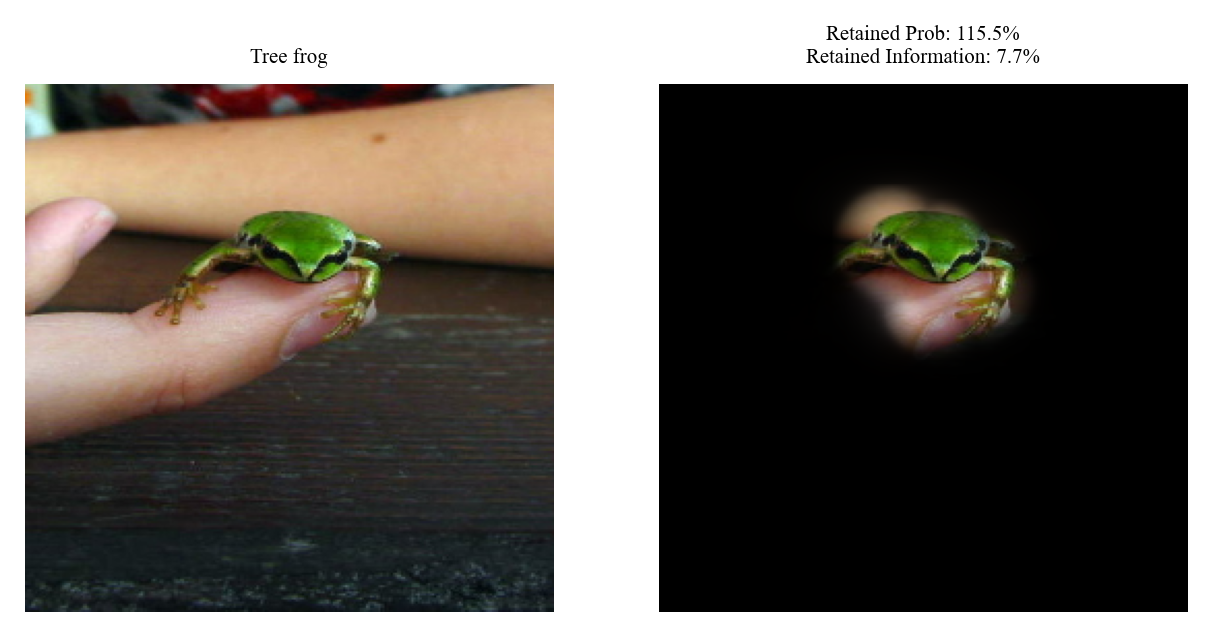

In [7]:
# ============================== Compute Smoothmask ==============================
area = 0.05 # How much area should be kept by smoothmask
smoothmask_method = SmoothMask(area, model)
smoothmask = smoothmask_method(x, preds[0].item())

# ============================== Plot Explanation ==============================
fig, axs = plt.subplots(1,2, dpi=250)
s = 6 # fontsize
# Input Image
axs[0].imshow(x.squeeze(0).permute(1,2,0).cpu())
axs[0].set_title(imagenet_labels_dict[preds[0].item()].split(',')[0].capitalize(), fontsize=s)
axs[0].axis('off')
# Smoothmask Visualization
axs[1].imshow(smoothmask.squeeze(0).permute(1,2,0).cpu())
axs[1].axis('off')
fidelity = nn.Softmax(dim=-1)(model(smoothmask)).max(1)[0].item()
acc = nn.Softmax(dim=-1)(model(x)).max(1)[0].item()
retained_prob_smoothmask = fidelity / acc
retained_information_smoothmask = smoothmask.abs().sum() / x.abs().sum()
axs[1].set_title(f'Retained Prob: {(100*retained_prob_smoothmask):.1f}%\nRetained Information: {(100*retained_information_smoothmask):.1f}%', fontsize=s)
plt.show()

### GradCAM

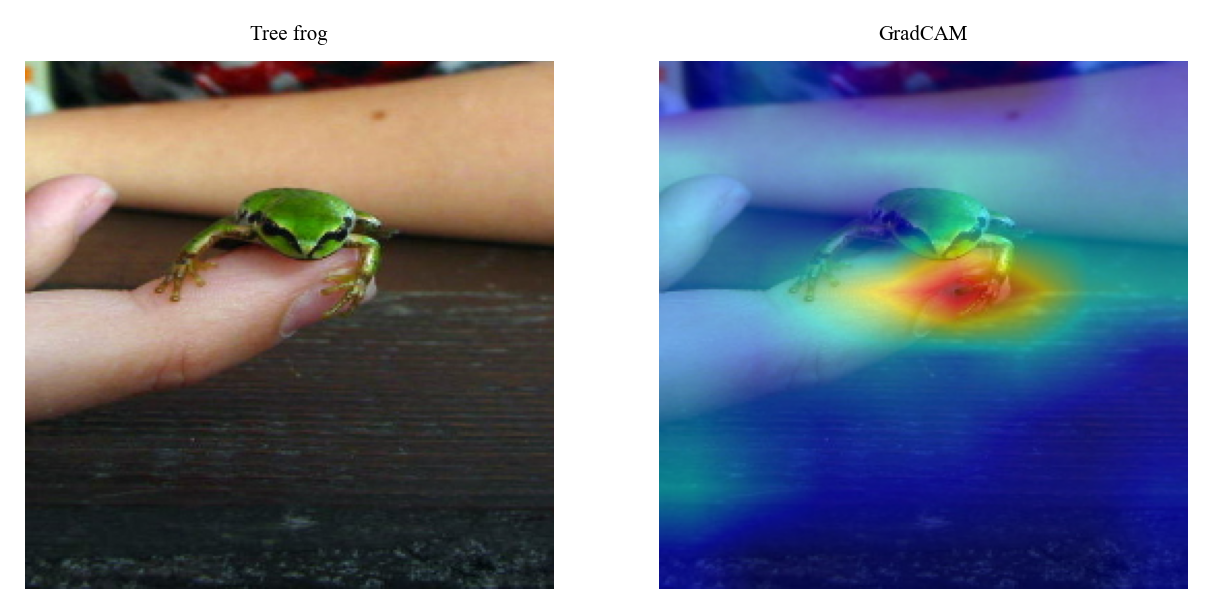

In [8]:
# ============================== Compute GradCAM ==============================
target_layer = '[1].features[-1]'
target_layers = [eval('model'+target_layer)]
targets = None
# Need paramters to require grad to compute gradcam
for param in model.parameters():
    param.requires_grad = True

# Construct the GradCAM object
gradcam_method = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
grayscale_cam = gradcam_method(input_tensor=x, targets=targets)
grayscale_cam = (grayscale_cam / grayscale_cam.max())

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
img = x.detach().squeeze(0).permute(1,2,0).cpu().numpy()
gradcam = torch.tensor(show_cam_on_image(img, grayscale_cam, use_rgb=True))

# Set grad to false now that gradcam is computed
for param in model.parameters():
    param.requires_grad = False

# ============================== Plot Explanation ==============================
fig, axs = plt.subplots(1,2, dpi=250)
s = 6 # fontsize
# Input Image
axs[0].imshow(x.squeeze(0).permute(1,2,0).cpu())
axs[0].set_title(imagenet_labels_dict[preds[0].item()].split(',')[0].capitalize(), fontsize=s)
axs[0].axis('off')
# GradCAM Visualization
axs[1].imshow(gradcam.squeeze(0).cpu())
axs[1].axis('off')
axs[1].set_title('GradCAM', fontsize=s)
plt.show()


### Visualize in one Figure

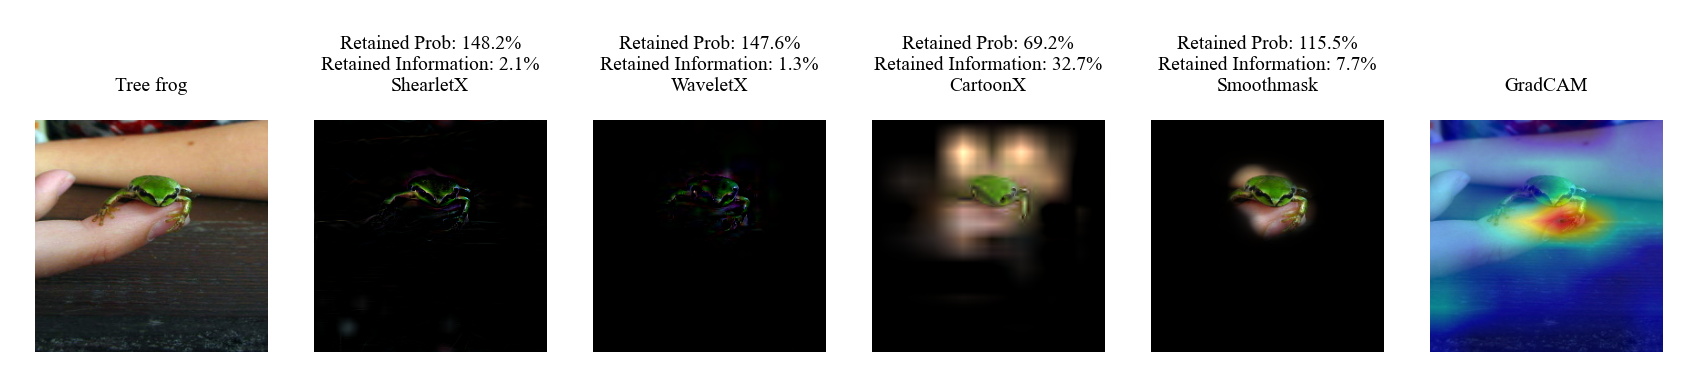

In [9]:
# ============================== Plot Explanation ==============================
fig, axs = plt.subplots(1,6, dpi=350)
s = 4 # fontsize
# Input Image
axs[0].imshow(x.squeeze(0).permute(1,2,0).cpu())
axs[0].set_title(imagenet_labels_dict[preds[0].item()].split(',')[0].capitalize(), fontsize=s)
axs[0].axis('off')

# ShearletX Visualization
axs[1].imshow(shearletx.squeeze(0).permute(1,2,0).cpu())
axs[1].axis('off')
axs[1].set_title(f'Retained Prob: {(100*retained_prob_shearletx):.1f}%'\
                 f'\nRetained Information: {(100*retained_information_shearletx):.1f}%\nShearletX', fontsize=s
)


# WaveletX Visualization
axs[2].imshow(waveletx.squeeze(0).permute(1,2,0).cpu())
axs[2].axis('off')
axs[2].set_title(f'Retained Prob: {(100*retained_prob_waveletx):.1f}%'\
                 f'\nRetained Information: {(100*retained_information_waveletx):.1f}%\nWaveletX', fontsize=s
)


# CartoonX Visualization
axs[3].imshow(cartoonx.squeeze(0).permute(1,2,0).cpu())
axs[3].axis('off')
axs[3].set_title(f'Retained Prob: {(100*retained_prob_cartoonx):.1f}%'\
                 f'\nRetained Information: {(100*retained_information_cartoonx):.1f}%\nCartoonX', fontsize=s
)


# Smoothmask Visualization
axs[4].imshow(smoothmask.squeeze(0).permute(1,2,0).cpu())
axs[4].axis('off')
axs[4].set_title(f'Retained Prob: {(100*retained_prob_smoothmask):.1f}%'\
                 f'\nRetained Information: {(100*retained_information_smoothmask):.1f}%\nSmoothmask', fontsize=s
)


# GradCAM Visualization
axs[5].imshow(gradcam.squeeze(0).cpu())
axs[5].axis('off')
axs[5].set_title('GradCAM', fontsize=s)
plt.show()


Previous methods like Smoothmask and GradCAM are by design very smooth to avoid explanation artifacts and cannot seperate the nearby finger from the frog leaving the question whether the finger was indeed relevant. ShearletX and WaveletX is able to mark fine features of the tree frog as relevant without marking the nearby finger. Our paper shows that we can seperate fine features such as the frog legs and head without creating explanation artifacts.

### Another Example
Let's compare another example of an [Afghan Hound](https://en.wikipedia.org/wiki/Afghan_Hound).

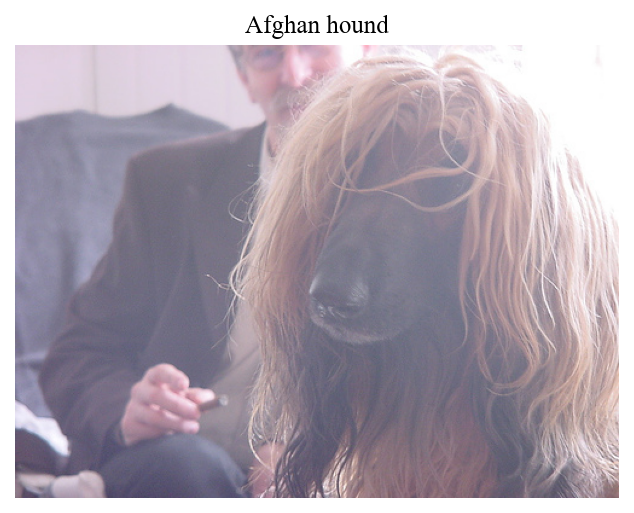

In [10]:
convert_to_tensor = transforms.Compose(
    [transforms.ToTensor(), transforms.Resize(size=(256,256))]
)
    

img = Image.open(os.path.join('imgs', 'ILSVRC2012_val_00017625.JPEG')).convert('RGB')
# Convert image to tensor
x = convert_to_tensor(img).unsqueeze(0).to(device)
# Get prediction for x
preds = nn.Softmax(dim=-1)(model(x)).max(1)[1].detach()

# Plot the image
plt.subplots(dpi=150)
plt.imshow(img)
plt.axis('off')
plt.title(imagenet_labels_dict[preds[0].item()].split(',')[0].capitalize())


# Show the plot
plt.show()


Iter 149/150

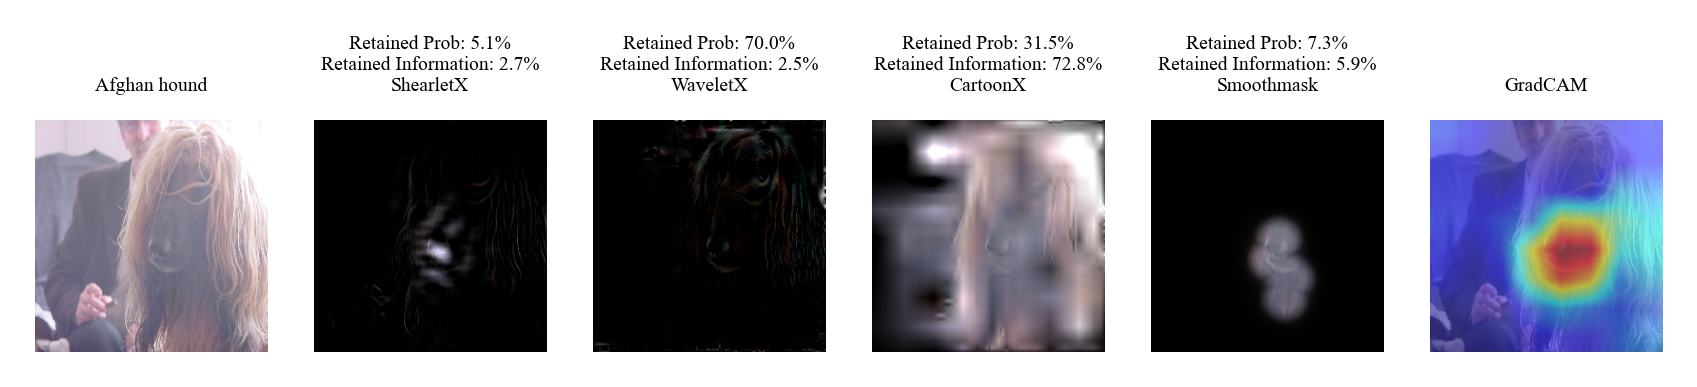

In [11]:
# Get prediction for x
preds = nn.Softmax(dim=-1)(model(x)).max(1)[1].detach()

# Hparams ShearletX with spatial reg
SHEARLETX_HPARAMS = {
    "l1lambda": 1., "lr": 1e-1, 'obfuscation': 'uniform',
    "maximize_label": True, "optim_steps": 150,  
    "noise_bs": 16, 'l1_reg': 2., 'mask_init': 'ones'
} 

# ============================== Compute ShearletX ===============================
shearletx_method = ShearletX(model=model, device=device, **SHEARLETX_HPARAMS)
shearletx, history_shearletx = shearletx_method(x, preds)
shearletx = shearletx/shearletx.max()

# ============================== Plot Explanation ==============================
fig, axs = plt.subplots(1,6, dpi=350)
s = 4 # fontsize
# Input Image
axs[0].imshow(x.squeeze(0).permute(1,2,0).cpu())
axs[0].set_title(imagenet_labels_dict[preds[0].item()].split(',')[0].capitalize(), fontsize=s)
axs[0].axis('off')

# ShearletX Visualization
axs[1].imshow(shearletx.squeeze(0).permute(1,2,0).cpu())
axs[1].axis('off')
fidelity = nn.Softmax(dim=-1)(model(shearletx)).max(1)[0].item()
acc = nn.Softmax(dim=-1)(model(x)).max(1)[0].item()
retained_prob = fidelity / acc
retained_information = shearletx.abs().sum() / x.abs().sum()
axs[1].set_title(f'Retained Prob: {(100*retained_prob):.1f}%\nRetained Information: {(100*retained_information):.1f}%\nShearletX', fontsize=s)


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


# Hparams WaveletX with spatial reg
WAVELETX_HPARAMS = {
    "l1lambda": 1., "lr": 1e-1, 'obfuscation': 'uniform',
    "maximize_label": True, "optim_steps": 150,  
    "noise_bs": 16, 'l1_reg': 35., 'mask_init': 'ones'
} 

# ============================== Compute WaveletX ===============================
waveletx_method = WaveletX(model=model, device=device, **WAVELETX_HPARAMS)
waveletx, history_waveletx = waveletx_method(x, preds)
waveletx = waveletx/waveletx.max()

# ============================== Plot Explanation ==============================
# WaveletX Visualization
axs[2].imshow(waveletx.squeeze(0).permute(1,2,0).cpu())
axs[2].axis('off')
fidelity = nn.Softmax(dim=-1)(model(waveletx)).max(1)[0].item()
acc = nn.Softmax(dim=-1)(model(x)).max(1)[0].item()
retained_prob = fidelity / acc
retained_information = waveletx.abs().sum() / x.abs().sum()
axs[2].set_title(f'Retained Prob: {(100*retained_prob):.1f}%\nRetained Information: {(100*retained_information):.1f}%\nWaveletX', fontsize=s)


# Hparams WaveletX with spatial reg
CARTOONX_HPARAMS = {
    "l1lambda": 155., "lr": 1e-1, 'obfuscation': 'uniform',
    "maximize_label": True, "optim_steps": 150,  
    "noise_bs": 16, 'mask_init': 'ones'
} 

# ============================== Compute CartoonX ===============================
cartoonx_method = CartoonX(model=model, device=device, **CARTOONX_HPARAMS)
cartoonx, history_cartoonx = cartoonx_method(x, preds)
cartoonx = cartoonx/cartoonx.max()

# ============================== Plot Explanation ==============================
# CartoonX Visualization
axs[3].imshow(cartoonx.squeeze(0).permute(1,2,0).cpu())
axs[3].axis('off')
fidelity = nn.Softmax(dim=-1)(model(cartoonx)).max(1)[0].item()
acc = nn.Softmax(dim=-1)(model(x)).max(1)[0].item()
retained_prob = fidelity / acc
retained_information = cartoonx.abs().sum() / x.abs().sum()
axs[3].set_title(f'Retained Prob: {(100*retained_prob):.1f}%\nRetained Information: {(100*retained_information):.1f}%\nCartoonX', fontsize=s)

# ============================== Compute Smoothmask ==============================
area = 0.05 # How much area should be kept by smoothmask
smoothmask_method = SmoothMask(area, model)
smoothmask = smoothmask_method(x, preds[0].item())

# ============================== Plot Explanation ==============================
# Smoothmask Visualization
axs[4].imshow(smoothmask.squeeze(0).permute(1,2,0).cpu())
axs[4].axis('off')
fidelity = nn.Softmax(dim=-1)(model(smoothmask)).max(1)[0].item()
acc = nn.Softmax(dim=-1)(model(x)).max(1)[0].item()
retained_prob = fidelity / acc
retained_information = smoothmask.abs().sum() / x.abs().sum()
axs[4].set_title(f'Retained Prob: {(100*retained_prob):.1f}%\nRetained Information: {(100*retained_information):.1f}%\nSmoothmask', fontsize=s)



# ============================== Compute GradCAM ==============================
target_layer = '[1].features[-1]'
target_layers = [eval('model'+target_layer)]
targets = None
# Need paramters to require grad to compute gradcam
for param in model.parameters():
    param.requires_grad = True

# Construct the GradCAM object
gradcam_method = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
grayscale_cam = gradcam_method(input_tensor=x, targets=targets)
grayscale_cam = (grayscale_cam / grayscale_cam.max())

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
img = x.detach().squeeze(0).permute(1,2,0).cpu().numpy()
gradcam = torch.tensor(show_cam_on_image(img, grayscale_cam, use_rgb=True))

# Set grad to false now that gradcam is computed
for param in model.parameters():
    param.requires_grad = False

# ============================== Plot Explanation ==============================
# GradCAM Visualization
axs[5].imshow(gradcam.squeeze(0).cpu())
axs[5].axis('off')
axs[5].set_title('GradCAM', fontsize=s)
plt.show()


Note how ShearletX is able to seperate very few long hairs of the Afghan Hound and mark them as relevant forming a nice sketch of the Afghan hound. ShearletX and WaveletX are useful tools to localize the classifier relevant part in detail and avoid rough overly smooth localizations such as Smoothmask and GradCAM.